In [1]:
def count_parameters_conv(in_channels: int, out_channels: int, kernel_size: int, bias: bool):
    return (in_channels*kernel_size**2+bias)*out_channels

In [4]:
import warnings
import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T

from PIL import Image 
from matplotlib import cm 
from time import perf_counter
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from tqdm import tqdm

In [26]:
from IPython.display import clear_output

In [6]:
warnings.filterwarnings('ignore')

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Optimizer


def create_model():
    model = nn.Sequential(
        nn.Linear(100,10),
        nn.ReLU(),
        nn.Linear(10,1)
    )

    return  model

def train(model: nn.Module, data_loader: DataLoader, optimizer: Optimizer, loss_fn):
    model.train()
    errors = 0
    for x, y in data_loader:
        optimizer.zero_grad()
        output = model(x)
        loss = loss_fn(output, y)
        loss.backward()
        print(f'{loss.item():.5f}')
        errors+= loss.item()
        optimizer.step()
    return errors/len(data_loader)


@torch.inference_mode()
def evaluate(model: nn.Module, data_loader: DataLoader, loss_fn):
    model.eval()
    errors = 0
    for x,y in data_loader:
        y_pred = model.forward(x)
        errors += loss_fn(y_pred, y)
    return errors/len(data_loader)

In [9]:
minist_train = MNIST('../datasets/mnist',
                    train = True,
                    download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|████████████████████████████| 9912422/9912422 [00:09<00:00, 1008082.32it/s]


Extracting ../datasets/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ../datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████████| 28881/28881 [00:00<00:00, 227581.46it/s]


Extracting ../datasets/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ../datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|█████████████████████████████| 1648877/1648877 [00:01<00:00, 921866.88it/s]


Extracting ../datasets/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ../datasets/mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 1281224.61it/s]

Extracting ../datasets/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../datasets/mnist/MNIST/raw



In [14]:
minist_train[16][0]

In [15]:
minist_train[16]

(<PIL.Image.Image image mode=L size=28x28>, 2)

In [16]:
minist_train = MNIST('../datasets/mnist',
                    train = True,
                    download=True,
                    transform=T.ToTensor())

In [17]:
minist_test = MNIST('../datasets/mnist',
                    train = False,
                    download=True,
                    transform=T.ToTensor())

In [32]:
train_loader = DataLoader(minist_train, batch_size=128, shuffle=True)
valid_loader = DataLoader(minist_test, batch_size=128, shuffle=True)

In [18]:
def train(model: nn.Module) -> float:
    model.train()

    train_loss = 0

    for x, y in tqdm(train_loader, desc='Train'):
        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)
    
    return train_loss

In [19]:
@torch.inference_mode()
def evaluate(model: nn.Module, loader: DataLoader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

In [20]:
def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(valid_accuracy)
    plt.grid()

    plt.show()

In [30]:
first_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28 * 28, 652),
    nn.ReLU(),
    nn.Linear(652, 520),
    nn.ReLU(),
    nn.Linear(520, 388),
    nn.ReLU(),
    nn.Linear(388, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
)

optimizer = torch.optim.Adam(first_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

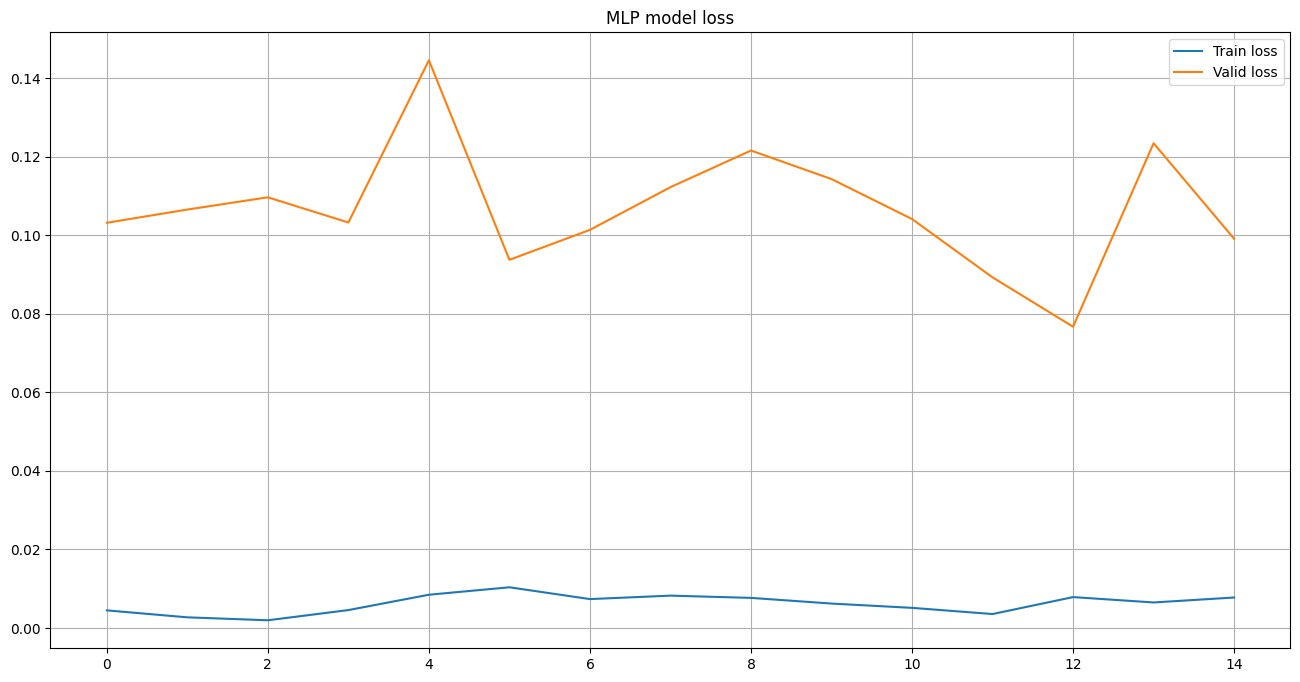

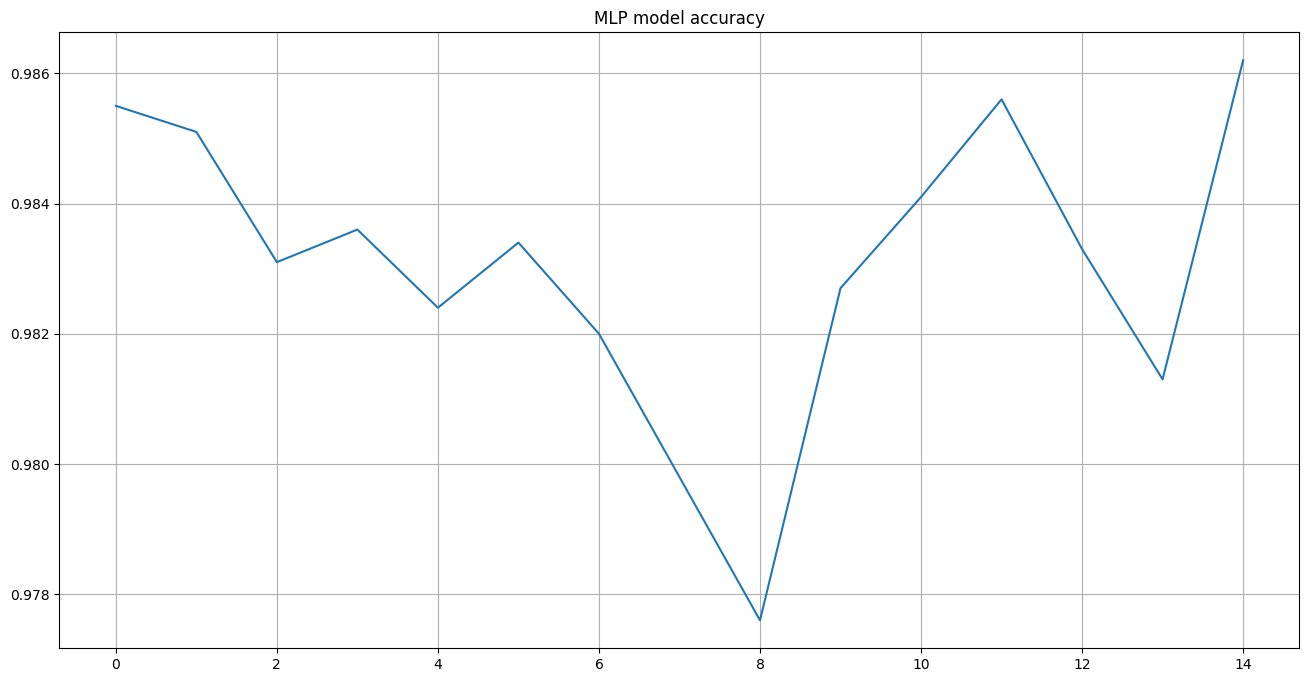

Total training and evaluation time 71.33645


In [33]:
num_epochs = 15

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(first_model)

    valid_loss, valid_accuracy = evaluate(first_model, valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)
    
    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'MLP model')
    
print(f'Total training and evaluation time {perf_counter() - start:.5f}')

In [36]:
torch.save(first_model.state_dict(), 'model.pt')

OrderedDict([('1.weight',
              tensor([[-0.0068, -0.0351,  0.0116,  ...,  0.0049, -0.0120, -0.0195],
                      [ 0.0191, -0.0046,  0.0003,  ..., -0.0092, -0.0114, -0.0216],
                      [ 0.0203,  0.0127, -0.0160,  ..., -0.0026,  0.0176, -0.0217],
                      ...,
                      [ 0.0079,  0.0329,  0.0069,  ..., -0.0343,  0.0140,  0.0243],
                      [-0.0149,  0.0171, -0.0011,  ...,  0.0053, -0.0103,  0.0281],
                      [ 0.0241,  0.0005,  0.0087,  ..., -0.0138, -0.0220,  0.0250]])),
             ('1.bias',
              tensor([-4.3386e-02,  5.5395e-02, -6.2624e-02,  4.4737e-02,  6.4752e-03,
                      -6.3863e-02, -9.4477e-02, -8.3805e-02,  8.7109e-02,  8.2836e-03,
                      -5.5120e-02, -8.9207e-02, -8.7982e-02, -5.5110e-02,  5.8664e-02,
                       1.1253e-03, -5.5451e-02, -1.2308e-01, -3.3656e-02,  7.0850e-03,
                      -1.0372e-01, -7.8608e-02,  6.9149e-04,  4.7058

In [43]:
second_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Flatten(),
    nn.Linear(4 * 4 * 64, 520),
    
    nn.ReLU(),
    nn.Linear(520, 256),

    
    nn.ReLU(),
    nn.Linear(256, 10)
)

optimizer = torch.optim.Adam(second_model.parameters(), lr=1e-3)

loss_fn = nn.CrossEntropyLoss()

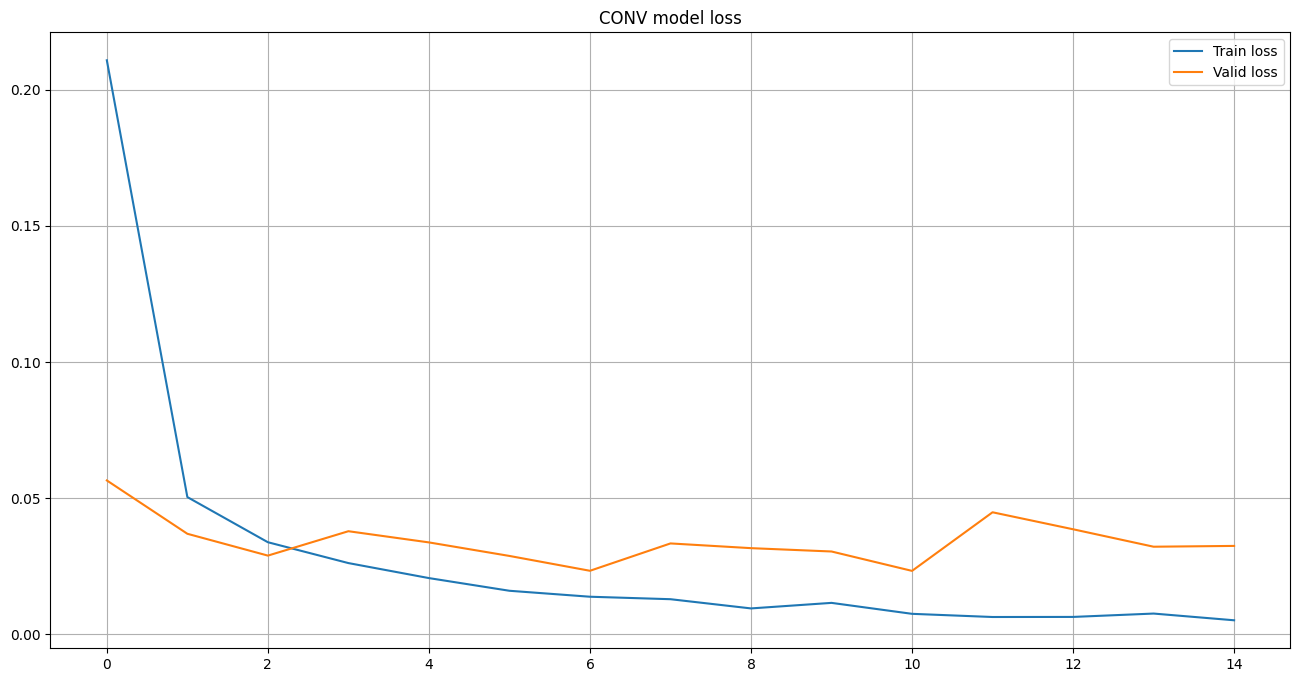

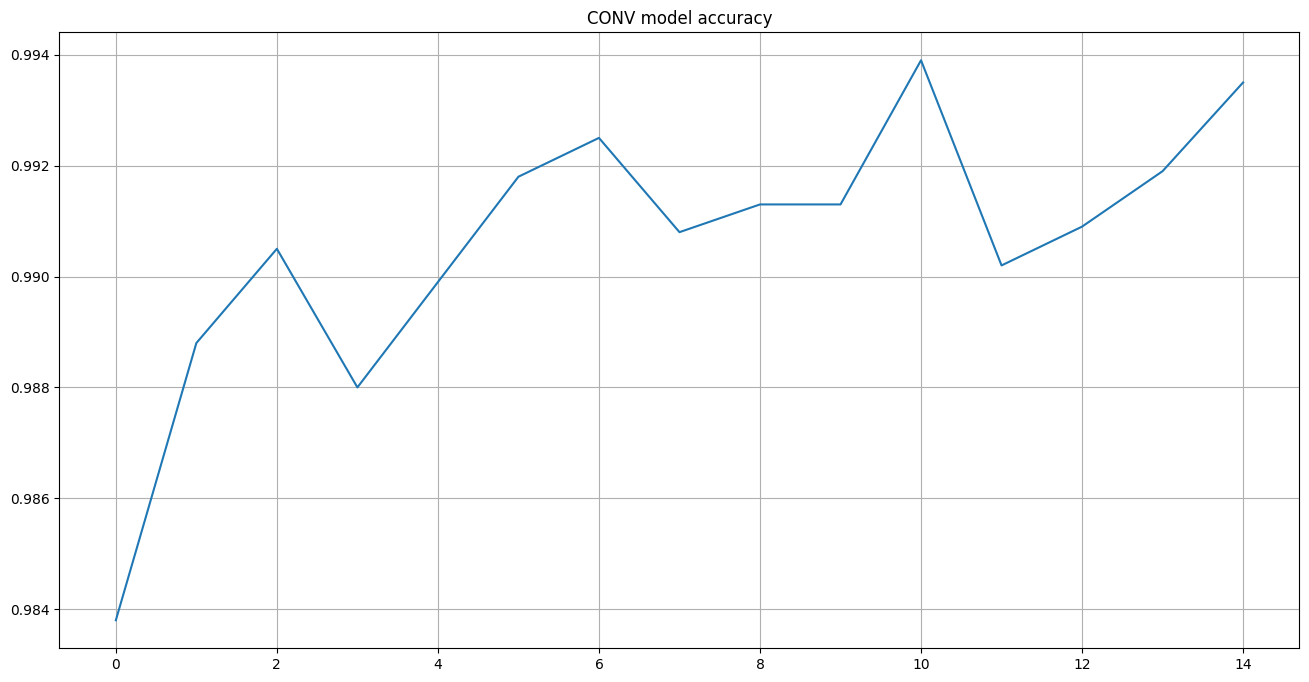

Total training and evaluation time 347.19274


In [44]:
num_epochs = 15

train_loss_history, valid_loss_history = [], []
valid_accuracy_history = []

start = perf_counter()

for epoch in range(num_epochs):
    train_loss = train(second_model)

    valid_loss, valid_accuracy = evaluate(second_model, valid_loader)

    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)
    valid_accuracy_history.append(valid_accuracy)

    clear_output()

    plot_stats(train_loss_history, valid_loss_history, valid_accuracy_history, 'CONV model')

print(f'Total training and evaluation time {perf_counter() - start:.5f}')

In [ ]:
torch.save(second_model.state_dict(), 'model.pt')

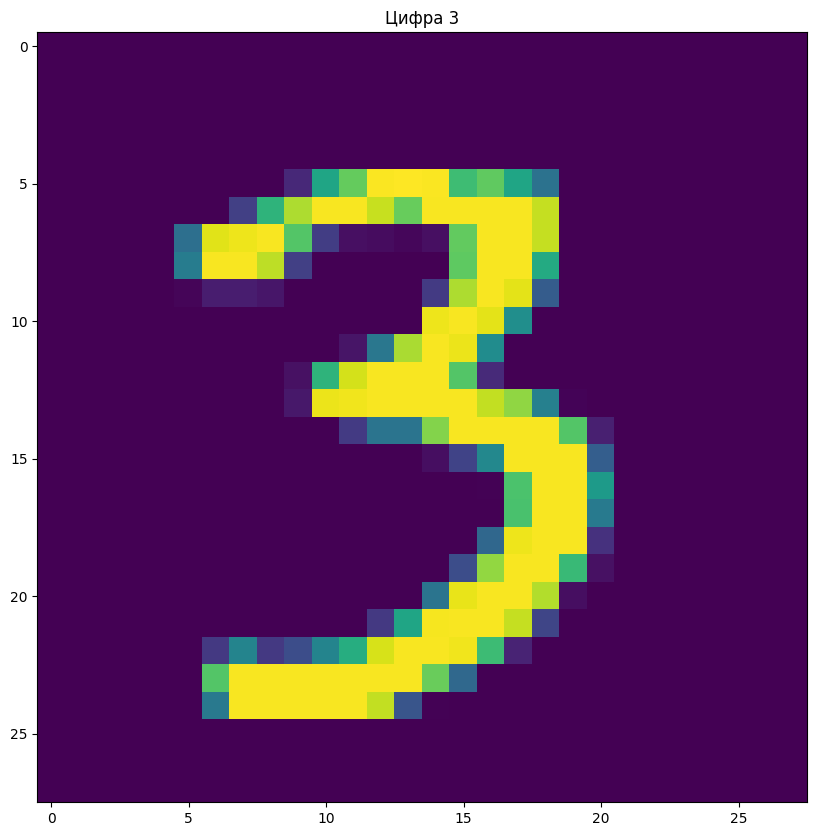

In [57]:
plt.figure(figsize=(10, 10))
plt.title(f'Цифра {minist_train[10000][1]}')
plt.imshow(minist_train[10000][0][0])

plt.show()

In [46]:
second_model()

TypeError: conv2d() received an invalid combination of arguments - got (tuple, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tuple of (Tensor, int)!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tuple of (Tensor, int)!, !Parameter!, !Parameter!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
